In [1]:
# import libraries
import numpy as np
import pandas as pd
import time
import math
import re

import sklearn.model_selection
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

from transformers import TokenAndPositionEmbedding, TransformerBlock

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from textwrap import wrap
import seaborn as sns

In [2]:
# import detected and undetected datasets
detected_peptides = pd.read_table('../data/detected_peptides_all_quant_aaindex1.tsv')
undetected_peptides = pd.read_table('../data/undetected_peptides_all_quant_aaindex1.tsv')

In [3]:
# keep detected and undetected peptides less than or equal to 40 aa AND greater than or equal to 7 aa in length
detected_peptides = detected_peptides.loc[(detected_peptides["Peptide"].str.len()>=7) & 
                                          (detected_peptides["Peptide"].str.len()<=40)].reset_index(drop=True)

undetected_peptides = undetected_peptides.loc[(undetected_peptides["Peptide"].str.len()>=7) & 
                                              (undetected_peptides["Peptide"].str.len()<=40)].reset_index(drop=True)

print(detected_peptides.shape)
print(undetected_peptides.shape)

(37837, 572)
(134282, 572)


In [4]:
# double check 0 peptides in undetected peptides are present in detected peptides
len(undetected_peptides[undetected_peptides["Peptide"].isin(detected_peptides["Peptide"])])

0

In [5]:
# # drop unnecessary columns
# detected_peptides = detected_peptides.drop(['Protein', 'PEP', 'Protein_length'], axis=1)
# undetected_peptides = undetected_peptides.drop(['Protein', 'PEP', 'Protein_length'], axis=1)

# print(detected_peptides.shape)
# print(undetected_peptides.shape)

(37837, 568)
(134282, 568)


In [5]:
# add detectability column
detected_peptides.insert(loc=1, column='Detectability', value=1)
undetected_peptides.insert(loc=1, column='Detectability', value=0)

print(detected_peptides.shape)
print(undetected_peptides.shape)

(37837, 573)
(134282, 573)


In [10]:
detected_peptides.head()

,Peptide,Detectability,SAF,NSAF,CBN_P,CBN_S,RSc,ANDN920101,ARGP820101,ARGP820102,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
0,DFSALESQLQDTQELLQEENR,1,0.204082,0.001112,0.004976,0.004809,-7.694861,4.396667,0.588571,1.080476,...,11.476190,18.101048,12.857143,21.619048,33.952714,6.378095,25.593476,-0.201286,9.946143,2.871429
1,NADMSEEMQQDSVECATQALEK,1,0.146067,0.000796,0.000335,0.000168,-12.592345,4.414091,0.557727,0.947727,...,10.363636,17.069591,12.045455,20.863636,31.091545,6.724545,24.802727,-0.200273,9.845545,2.798636
2,ASASGSGAQVGGPISSGSSASSVTVTR,1,0.195783,0.001067,0.001738,0.001571,-9.317300,4.275556,0.447037,0.887037,...,6.222222,11.036333,7.185185,14.444444,20.185963,5.917407,17.876037,-0.373889,7.676667,3.904519
3,LSEEEILENPDLFLTSEATDYGR,1,0.069401,0.000378,0.000443,0.000276,-11.855223,4.367391,0.826087,1.036957,...,11.043478,16.858000,12.043478,20.521739,32.217696,6.162174,24.468783,-0.480652,9.732957,3.378174
4,IMQSSSEVGYDAMAGDFVNMVEK,1,0.335079,0.001826,0.002482,0.002315,-8.755417,4.362609,0.791304,0.983913,...,10.260870,16.334217,11.260870,20.391304,29.870783,6.409565,23.353304,-0.120870,9.540174,2.903000


In [7]:
# remove nan values
all_peptides = pd.concat([detected_peptides, undetected_peptides])
print(all_peptides.shape)
all_peptides = all_peptides.dropna(axis=1, how='any')
print(all_peptides.shape)
detected_peptides = all_peptides[all_peptides['Detectability'] == 1]
undetected_peptides = all_peptides[all_peptides['Detectability'] == 0]
print(detected_peptides.shape)
print(undetected_peptides.shape)

(172119, 573)
(172119, 560)
(37837, 560)
(134282, 560)


In [11]:
# take random sample of undetected_peptides, with equal number of rows to detected_peptides
# random_state is used for reproducibility
undetected_peptides_balanced = undetected_peptides.sample(n=detected_peptides.shape[0], 
                                                         random_state=42).reset_index(drop=True)
print(detected_peptides.shape)
print(undetected_peptides_balanced.shape)

(37837, 560)
(37837, 560)


In [12]:
undetected_peptides_balanced

,Peptide,Detectability,SAF,NSAF,CBN_P,CBN_S,RSc,ANDN920101,ARGP820101,ARGP820102,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
0,IWRPPMYQR,0,0.001679,0.000009,0.000203,0.000036,-15.025494,4.420000,1.447778,0.880000,...,16.222222,22.903889,16.333333,27.777778,41.222222,6.043000,26.303556,-0.265556,11.556222,4.880111
1,NGTHLDAGALTTTFEELHFEIKPHDDCTVEQIYEILK,0,0.043841,0.000239,0.000431,0.000264,-11.920829,4.360541,0.880270,0.960811,...,10.675676,16.589649,12.135135,20.027027,32.432811,5.968649,24.141703,-0.880486,9.630378,3.044514
2,MAEESER,0,0.005042,0.000027,0.000215,0.000048,-14.540050,4.374286,0.550000,0.764286,...,12.142857,20.139143,13.428571,25.142857,34.142857,6.620000,24.697143,0.000000,10.133571,2.617429
3,AVGGAMR,0,0.024155,0.000132,0.000239,0.000072,-13.887939,4.212857,0.637143,1.041429,...,8.142857,12.592000,8.285714,15.428571,21.001000,5.428571,16.669571,0.000000,7.466714,1.836571
4,NIVHNYSEAEIK,0,0.003472,0.000019,0.000203,0.000036,-15.025494,4.364167,0.926667,0.630833,...,11.250000,17.617500,13.000000,22.166667,33.668417,6.246667,24.482833,-0.512917,9.749167,2.747167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37832,CGTVGSR,0,0.003530,0.000019,0.000227,0.000060,-14.177463,4.252857,0.461429,0.851429,...,6.428571,13.049143,8.000000,16.857143,22.858143,5.722857,19.023143,-0.603857,7.952429,4.028571
37833,ALVIAPLFGIAQVVYFLGIAESLLGLLQDPQA,0,0.006192,0.000034,0.000203,0.000036,-15.025494,4.250313,1.105938,1.459062,...,9.843750,13.765969,10.312500,16.000000,27.063156,5.906875,21.680187,-0.183844,8.904875,2.996844
37834,YQEDFNPLVR,0,0.016867,0.000092,0.000263,0.000096,-13.440445,4.437000,1.029000,0.873000,...,13.300000,19.564100,14.300000,23.200000,37.301400,6.179000,26.451300,-0.096000,10.705600,3.857800
37835,EESELQR,0,0.000984,0.000005,0.000203,0.000036,-15.025494,4.327143,0.512857,0.778571,...,12.142857,20.648714,13.857143,25.428571,36.571429,6.405714,26.055429,0.000000,10.205000,2.946857


In [13]:
unused_undetected = undetected_peptides[~undetected_peptides["Peptide"].isin
                                        (undetected_peptides_balanced["Peptide"])]
unused_undetected.shape

(96445, 560)

# Create training, validation and test sets

## Split into train and test sets

In [14]:
# detected peptides
X_trainP, X_testP, y_trainP, y_testP = sklearn.model_selection.train_test_split(
    detected_peptides, detected_peptides['Detectability'], test_size=0.3, random_state=1)

In [15]:
# undetected peptides
X_trainN, X_testN, y_trainN, y_testN = sklearn.model_selection.train_test_split(
    undetected_peptides_balanced, undetected_peptides_balanced['Detectability'], test_size=0.3, random_state=1)

In [16]:
print(X_trainP.shape)
print(X_testP.shape)
print('')
print(X_trainN.shape)
print(X_testN.shape)

(26485, 560)
(11352, 560)

(26485, 560)
(11352, 560)


## split training into train and validation sets

In [17]:
# detected peptides
X_trainP, X_valP, y_trainP, y_valP = sklearn.model_selection.train_test_split(
    X_trainP, y_trainP, test_size=0.25, random_state=1)

In [18]:
# undetected peptides
X_trainN, X_valN, y_trainN, y_valN = sklearn.model_selection.train_test_split(
    X_trainN, y_trainN, test_size=0.25, random_state=1)

In [19]:
print(X_trainP.shape)
print(X_valP.shape)
print('')
print(X_trainN.shape)
print(X_valN.shape)

(19863, 560)
(6622, 560)

(19863, 560)
(6622, 560)


## create final training and validation sets

In [20]:
# create final training and validation sets
X_train = pd.concat([X_trainP, X_trainN])
X_val = pd.concat([X_valP] + [X_valN])
y_train = pd.concat([pd.Series(y_trainP)] + [pd.Series(y_trainN)])
y_val = pd.concat([pd.Series(y_valP)] + [pd.Series(y_valN)])

In [21]:
print(X_train.shape)
print(X_val.shape)
print('')
print(y_train.shape)
print(y_val.shape)

(39726, 560)
(13244, 560)

(39726,)
(13244,)


In [22]:
# check validation set is not in train
print(len(X_val[X_val["Peptide"].isin(X_train["Peptide"])]))

0


## create final test set

In [23]:
# create final test set
X_test = pd.concat([X_testP, X_testN])
y_test = pd.concat([pd.Series(y_testP)] + [pd.Series(y_testN)])
print(X_test.shape)
print(y_test.shape)

(22704, 560)
(22704,)


In [24]:
# check test is not in train or validation
print(len(X_test[X_test["Peptide"].isin(X_val["Peptide"])]))
print(len(X_test[X_test["Peptide"].isin(X_train["Peptide"])]))

0
0


## Pre-processing of train, validation and test sets

In [25]:
# integer-encode peptides
maxLength = 40

aaDict = {"-": 0, "A": 1, "R": 2, "N": 3, "D": 4, "C": 5, "Q": 6, "E": 7, "G": 8, "H": 9, "I": 10, "L": 11, 
          "K": 12, "M": 13, "F": 14, "P": 15, "S": 16, "T": 17, "W": 18, "Y": 19, "V": 20, "U": 21}

def convertPeptide(peptide, maxLength):
    j = 0
    hotPeptide = []
    for aa in peptide:
        hotPeptide.append(aaDict[aa])
        j = j + 1
    for k in range(maxLength - j):
        hotPeptide.append(0)

    return np.array(hotPeptide)

### Separate out each feature

In [34]:
# training set
X_train = shuffle(X_train, random_state=1).reset_index(drop=True)
y_train = shuffle(y_train, random_state=1).reset_index(drop=True)

X_train_peptide = X_train['Peptide'].apply(convertPeptide, args=(maxLength,))
# X_train_nsaf = X_train['Quantification']
X_train_quant = X_train.iloc[:, 2:7]
X_train_aaindex1 = X_train.iloc[:, 7:]

In [35]:
# validation set
X_val = shuffle(X_val, random_state=1).reset_index(drop=True)
y_val = shuffle(y_val, random_state=1).reset_index(drop=True)

X_val_peptide = X_val['Peptide'].apply(convertPeptide, args=(maxLength,))
# X_val_nsaf = X_val['Quantification']
X_val_quant = X_val.iloc[:, 2:7]
X_val_aaindex1 = X_val.iloc[:, 7:]

In [36]:
# test set
X_test = shuffle(X_test, random_state=1).reset_index(drop=True)
y_test = shuffle(y_test, random_state=1).reset_index(drop=True)

X_test_peptide = X_test['Peptide'].apply(convertPeptide, args=(maxLength,))
# X_test_nsaf = X_test['Quantification']
X_test_quant = X_test.iloc[:, 2:7]
X_test_aaindex1 = X_test.iloc[:, 7:]

In [37]:
np.asarray(X_test_aaindex1).shape

(22704, 553)

In [38]:
# convert to arrays
X_train_peptide = np.array(X_train_peptide.to_list())
X_val_peptide = np.array(X_val_peptide.to_list())
X_test_peptide = np.array(X_test_peptide.to_list())

## Further preprocessing

### Apply variance threshold

In [39]:
# apply variance threshold
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.005).fit(X_train_aaindex1)
mask = selector.get_support()

X_train_aaindex1 = X_train_aaindex1.loc[:, mask]
X_val_aaindex1 = X_val_aaindex1.loc[:, mask]
X_test_aaindex1 = X_test_aaindex1.loc[:, mask]

In [40]:
X_test_aaindex1.shape

(22704, 456)

### Apply scaling

In [100]:
# scale training set
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train_aaindex1)

X_train_aaindex1_scaled = scaler.transform(X_train_aaindex1)
X_val_aaindex1_scaled = scaler.transform(X_val_aaindex1)
X_test_aaindex1_scaled = scaler.transform(X_test_aaindex1)

### Apply PCA

In [113]:
# Apply scaled PCA

# scale first
scaler = preprocessing.StandardScaler().fit(X_train_aaindex1)
X_train_aaindex1_scaled = scaler.transform(X_train_aaindex1)
X_val_aaindex1_scaled = scaler.transform(X_val_aaindex1)
X_test_aaindex1_scaled = scaler.transform(X_test_aaindex1)

from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(np.asanyarray(X_train_aaindex1_scaled))

PCA(n_components=10)

In [114]:
print(pca.explained_variance_ratio_)

[0.34487805 0.18722858 0.13135246 0.07365784 0.04301389 0.0347896
 0.02940149 0.02639445 0.0239503  0.01754571]


In [115]:
X_train_aaindex1_pca = pca.transform(np.asanyarray(X_train_aaindex1_scaled))
X_val_aaindex1_pca = pca.transform(np.asanyarray(X_val_aaindex1_scaled))
X_test_aaindex1_pca = pca.transform(np.asanyarray(X_test_aaindex1_scaled))

In [120]:
print(pca.singular_values_)

[2752.53445285 2028.08456769 1698.70937262 1272.06552779  972.08519743
  874.22804326  803.68279977  761.47607417  725.36315178  620.84823999]


In [135]:
# PCA on original raw data (without scaling)
pca = PCA(n_components=3)
pca.fit(np.asanyarray(X_train_aaindex1))

print(pca.explained_variance_ratio_)

[0.44435436 0.32180917 0.11659419]


In [136]:
X_train_aaindex1_pca = pca.transform(np.asanyarray(X_train_aaindex1))
X_val_aaindex1_pca = pca.transform(np.asanyarray(X_val_aaindex1))
X_test_aaindex1_pca = pca.transform(np.asanyarray(X_test_aaindex1))

### Remove highly correlated (redundant) features

In [41]:
X_train_aaindex1_corr = X_train_aaindex1.corr()

In [42]:
correlated_features = set()
for i in range(len(X_train_aaindex1_corr.columns)):
    for j in range(i):
        if abs(X_train_aaindex1_corr.iloc[i, j]) > 0.5:
            colname = X_train_aaindex1_corr.columns[i]
            correlated_features.add(colname)

len(correlated_features)

452

In [43]:
X_train_aaindex1_corr = X_train_aaindex1
X_val_aaindex1_corr = X_val_aaindex1
X_test_aaindex1_corr = X_test_aaindex1

In [44]:
X_train_aaindex1_corr.drop(labels=correlated_features, axis=1, inplace=True)
X_val_aaindex1_corr.drop(labels=correlated_features, axis=1, inplace=True)
X_test_aaindex1_corr.drop(labels=correlated_features, axis=1, inplace=True)

In [45]:
X_train_aaindex1_corr.shape

(39726, 4)

In [73]:
# X_train_aaindex1_corr.columns
# for corr 0.5

Index(['ANDN920101', 'ARGP820101', 'ARGP820102', 'WERD780103'], dtype='object')

In [120]:
X_train_aaindex1_corr.columns
# for corr 0.6

Index(['ANDN920101', 'ARGP820101', 'ARGP820102', 'BEGF750101', 'BUNA790101',
       'CHAM820102', 'CHAM830105', 'CHAM830107', 'DAYM780201', 'FINA910103',
       'JOND750102', 'MAXF760103', 'QIAN880123', 'RICJ880117', 'TANS770108',
       'WERD780103', 'KARS160120'],
      dtype='object')

# Build model (Keras)

In [35]:
# keras.utils.plot_model(model, "original_model.png", show_shapes=True)

### New transformer network architecture

In [59]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

main_input = tf.keras.layers.Input(shape=(40,))
# embed each peptide into a 40-dimensional vector
embedding_layer = TokenAndPositionEmbedding(40, 21, embed_dim)
x = embedding_layer(main_input)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
lstm_out = tf.keras.layers.GlobalAveragePooling1D()(x)
auxiliary_output = tf.keras.layers.Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

auxiliary_input = tf.keras.layers.Input(shape=(5,), name='aux_input')
aaindex_input = tf.keras.layers.Input(shape=(4,), name='aaindex_input')

x = tf.keras.layers.concatenate([auxiliary_output, auxiliary_input, aaindex_input])

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

main_output = tf.keras.layers.Dense(1, activation='sigmoid', name='main_output')(x)

model = tf.keras.Model(inputs=[main_input, auxiliary_input, aaindex_input], outputs=[main_output, auxiliary_output])

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'], loss_weights=[1., 0.2])

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
token_and_position_embedding_2  (None, 40, 32)       1952        input_3[0][0]                    
__________________________________________________________________________________________________
transformer_block_2 (Transforme (None, 40, 32)       6464        token_and_position_embedding_2[0]
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 32)           0           transformer_block_2[0][0]        
____________________________________________________________________________________________

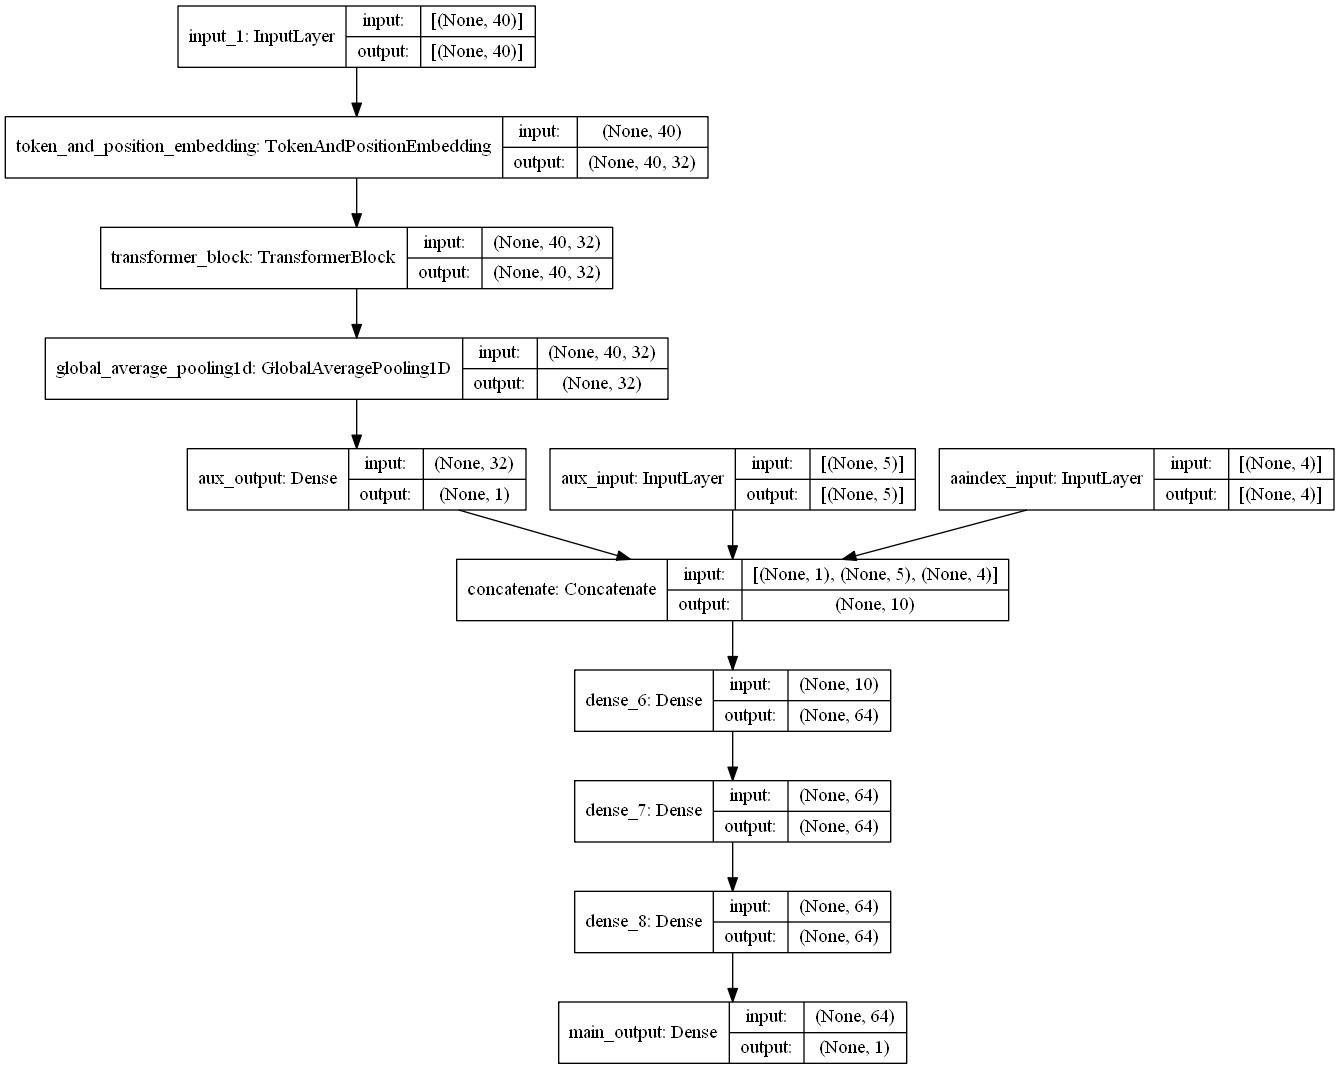

In [48]:
keras.utils.plot_model(model, "final_figures/keras_model.png", show_shapes=True)

In [60]:
start_time = time.time()

history = model.fit([np.asanyarray(X_train_peptide), np.asanyarray(X_train_quant), np.asanyarray(X_train_aaindex1_corr)], 
                    [np.asanyarray(y_train), np.asanyarray(y_train)], 
                    validation_data = ([np.asarray(X_val_peptide), np.asanyarray(X_val_quant), np.asarray(X_val_aaindex1_corr)], 
                                       [np.asarray(y_val), np.asarray(y_val)]), 
                    epochs=250, batch_size=134, verbose=2)

print("")
print("Time taken for model to run: ", time.time() - start_time)

Epoch 1/250
297/297 - 7s - loss: 0.8089 - main_output_loss: 0.6735 - aux_output_loss: 0.6769 - main_output_accuracy: 0.6376 - aux_output_accuracy: 0.5621 - val_loss: 0.7418 - val_main_output_loss: 0.6103 - val_aux_output_loss: 0.6571 - val_main_output_accuracy: 0.7098 - val_aux_output_accuracy: 0.6077
Epoch 2/250
297/297 - 4s - loss: 0.7112 - main_output_loss: 0.5820 - aux_output_loss: 0.6456 - main_output_accuracy: 0.7127 - aux_output_accuracy: 0.6226 - val_loss: 0.6838 - val_main_output_loss: 0.5586 - val_aux_output_loss: 0.6260 - val_main_output_accuracy: 0.7233 - val_aux_output_accuracy: 0.6459
Epoch 3/250
297/297 - 4s - loss: 0.6765 - main_output_loss: 0.5489 - aux_output_loss: 0.6382 - main_output_accuracy: 0.7259 - aux_output_accuracy: 0.6353 - val_loss: 0.6603 - val_main_output_loss: 0.5347 - val_aux_output_loss: 0.6281 - val_main_output_accuracy: 0.7354 - val_aux_output_accuracy: 0.6532
Epoch 4/250
297/297 - 4s - loss: 0.6625 - main_output_loss: 0.5347 - aux_output_loss: 0.638

In [61]:
history_dict = history.history
history_dict.keys()

# save to df
df_acc = pd.DataFrame({'Loss': history_dict['loss'], 
                       'main_output_loss': history_dict['main_output_loss'], 
                       'aux_output_loss': history_dict['aux_output_loss'], 
                      'main_output_accuracy': history_dict['main_output_accuracy'], 
                       'aux_output_accuracy': history_dict['aux_output_accuracy'], 
                      'val_loss': history_dict['val_loss'], 
                       'val_main_output_loss': history_dict['val_main_output_loss'], 
                       'val_aux_output_loss': history_dict['val_aux_output_loss'],
                      'val_main_output_accuracy': history_dict['val_main_output_accuracy'], 
                       'val_aux_output_accuracy': history_dict['val_aux_output_accuracy']})

In [493]:
#df_acc_aaindex1 = pd.DataFrame({'raw_acc': history_dict['val_main_output_accuracy']})
#df_acc_aaindex1['var_scaled'] = history_dict['val_main_output_accuracy']
# df_acc_aaindex1['scaled'] = history_dict['val_main_output_accuracy']
#df_acc_aaindex1['scaled_pca'] = history_dict['val_main_output_accuracy']
#df_acc_aaindex1['raw_pca'] = history_dict['val_main_output_accuracy']
#df_acc_aaindex1['corr_0.8'] = history_dict['val_main_output_accuracy']
#df_acc_aaindex1['corr_0.5'] = history_dict['val_main_output_accuracy']
#df_acc_aaindex1['corr_0.7'] = history_dict['val_main_output_accuracy']
#df_acc_aaindex1['var_corr_0.6'] = history_dict['val_main_output_accuracy']
df_acc_aaindex1['var_corr_0.5'] = history_dict['val_main_output_accuracy']
df_acc_aaindex1

,raw_acc,var_scaled,scaled,scaled_pca,raw_pca,corr_0.8,corr_0.5,corr_0.7,var_corr_0.6,var_corr_0.5
0,0.616581,0.637949,0.653277,0.624358,0.571202,0.575279,0.531788,0.582075,0.527635,0.532468
1,0.641347,0.647236,0.660375,0.632060,0.579885,0.585246,0.614618,0.597252,0.511703,0.623226
2,0.641649,0.650332,0.658638,0.634929,0.588040,0.603368,0.652446,0.580640,0.572033,0.635835
3,0.634551,0.655316,0.664905,0.635533,0.590381,0.594760,0.649879,0.578526,0.552024,0.645575
4,0.641951,0.661356,0.665886,0.637496,0.594533,0.607520,0.653352,0.573241,0.579583,0.656373
...,...,...,...,...,...,...,...,...,...,...
245,0.706660,0.672531,0.655316,0.676457,0.702205,0.695258,0.698581,0.704017,0.704923,0.700997
246,0.702809,0.674494,0.656599,0.679251,0.691709,0.696089,0.699638,0.696466,0.702809,0.704394
247,0.700921,0.678194,0.664452,0.680082,0.691709,0.693673,0.703639,0.699336,0.706358,0.700317
248,0.701827,0.669209,0.661205,0.675023,0.691634,0.692465,0.698731,0.698958,0.705150,0.702507


In [527]:
df_acc_aaindex1.to_csv('final_data/M7_seq_aaindex1_all-val-scores_134batch_250epoch.tsv', sep='\t', index=False)

In [523]:
df_acc_aaindex1.describe(include='all')

,raw_acc,var_scaled,scaled,scaled_pca,raw_pca,corr_0.8,corr_0.5,corr_0.7,var_corr_0.6,var_corr_0.5
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.685180,0.680349,0.670535,0.672909,0.678815,0.681818,0.691731,0.684437,0.688361,0.692429
std,0.021853,0.006480,0.006372,0.010268,0.026144,0.020455,0.014512,0.023814,0.025724,0.014807
min,0.571806,0.637949,0.653277,0.624358,0.571202,0.575279,0.531788,0.573241,0.511703,0.532468
25%,0.675891,0.678118,0.665754,0.673229,0.677571,0.677779,0.688236,0.681460,0.686122,0.689123
50%,0.693559,0.681780,0.671021,0.676155,0.688916,0.687179,0.695221,0.692200,0.693408,0.696315
75%,0.700827,0.684140,0.675853,0.677967,0.693635,0.693899,0.699241,0.698373,0.700204,0.699977
max,0.707415,0.690879,0.682724,0.681894,0.702205,0.703035,0.703941,0.704696,0.707792,0.706282


In [45]:
df_acc.to_csv('final_data/M8_seq_nsaf_aaindex1_var_corr05_REDO_train_134batch_250epoch.tsv', sep='\t', index=False)

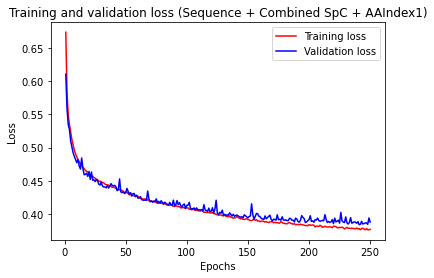

In [63]:
# plot training and validation loss
import matplotlib.pyplot as plt

train_loss = history_dict['main_output_loss']
val_loss = history_dict['val_main_output_loss']

acc = history_dict['main_output_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (Sequence + Combined SpC + AAIndex1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('final_figures/M8_seq_combSpC_aaindex1_var_corr05_REDO_train_val_loss_134b_250ep', dpi=200)
plt.show()

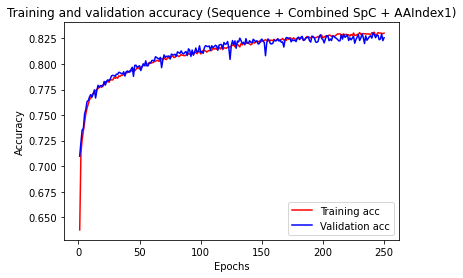

In [64]:
# plot training and validation accuracy
plt.clf()
train_acc = history_dict['main_output_accuracy']
val_acc = history_dict['val_main_output_accuracy']

plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy (Sequence + Combined SpC + AAIndex1)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('final_figures/M8_seq_combSpC_aaindex1_var_corr05_REDO_train_val_acc_134b_250ep', dpi=200)
plt.show()

### Plot validation accuracies for different approaches

In [31]:
# load validation scores
df_acc_aaindex1 = pd.read_table('final_data/M7_seq_aaindex1_all-val-scores_134batch_250epoch.tsv')
df_acc = pd.read_table('final_data/M7_seq_saf_aaindex1_train_134batch_250epoch.tsv')
df = pd.read_table('final_data/M7_seq_nsaf_aaindex1_var-corr05_pred_134b_250ep.tsv')

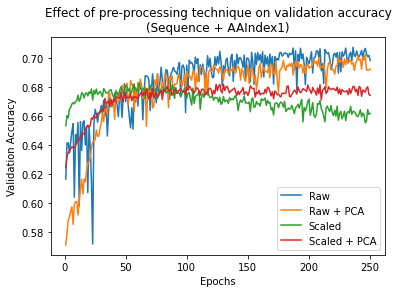

In [23]:
# plot training and validation accuracy
plt.clf()

epochs = range(1, len(df_acc_aaindex1['scaled_pca']) + 1)

plt.plot(epochs, df_acc_aaindex1['raw_acc'], 'tab:blue', label='Raw')
plt.plot(epochs, df_acc_aaindex1['raw_pca'], 'tab:orange', label='Raw + PCA')
plt.plot(epochs, df_acc_aaindex1['scaled'], 'tab:green', label='Scaled')
#plt.plot(epochs, df_acc_aaindex1['var_scaled'], 'tab:orange', label='Scaled + variance threshold')
plt.plot(epochs, df_acc_aaindex1['scaled_pca'], 'tab:red', label='Scaled + PCA')

# plt.plot(epochs, df_acc_aaindex1['corr_0.8'], 'tab:pink', label='Correlation')
# plt.plot(epochs, df_acc_aaindex1['corr_0.5'], 'tab:brown', label='Correlation')

plt.title("\n".join(wrap('Effect of pre-processing technique on validation accuracy (Sequence + AAIndex1)', 60)))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.savefig('final_figures/M7_seq_aaindex1_val_acc_preprocessing_134b_250ep', dpi=200)
plt.show()

<Figure size 432x288 with 0 Axes>

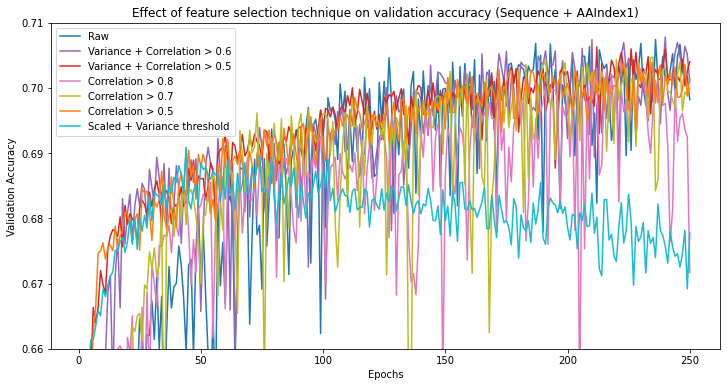

In [544]:
# plot training and validation accuracy
plt.clf()
train_acc = history_dict['main_output_accuracy']
val_acc = history_dict['val_main_output_accuracy']

epochs = range(1, len(df_acc_aaindex1['scaled_pca']) + 1)

figure(figsize=(12, 6))
plt.ylim(0.66, 0.71)

plt.plot(epochs, df_acc_aaindex1['raw_acc'], 'tab:blue', label='Raw')
plt.plot(epochs, df_acc_aaindex1['var_corr_0.6'], 'tab:purple', label='Variance + Correlation > 0.6')
plt.plot(epochs, df_acc_aaindex1['var_corr_0.5'], 'tab:red', label='Variance + Correlation > 0.5')
plt.plot(epochs, df_acc_aaindex1['corr_0.8'], 'tab:pink', label='Correlation > 0.8')
plt.plot(epochs, df_acc_aaindex1['corr_0.7'], 'tab:olive', label='Correlation > 0.7')
plt.plot(epochs, df_acc_aaindex1['corr_0.5'], 'tab:orange', label='Correlation > 0.5')
plt.plot(epochs, df_acc_aaindex1['var_scaled'], 'tab:cyan', label='Scaled + Variance threshold')

plt.title('Effect of feature selection technique on validation accuracy (Sequence + AAIndex1)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.savefig('final_figures/M7_seq_aaindex1_val_acc_feature_sel_134b_250ep', dpi=400)
plt.show()

<Figure size 432x288 with 0 Axes>

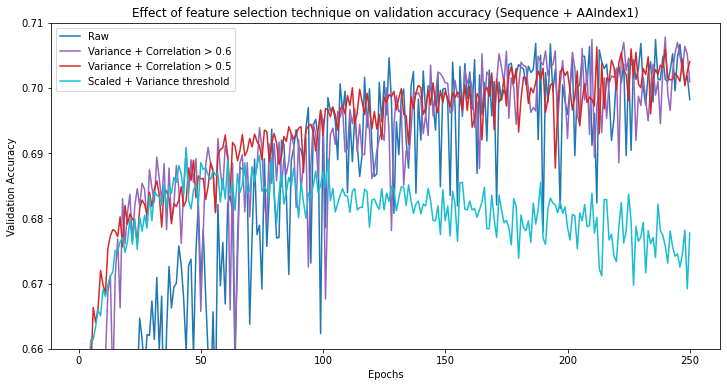

In [548]:
# plot training and validation accuracy
plt.clf()
train_acc = history_dict['main_output_accuracy']
val_acc = history_dict['val_main_output_accuracy']

epochs = range(1, len(df_acc_aaindex1['scaled_pca']) + 1)

figure(figsize=(12, 6))
plt.ylim(0.66, 0.71)

plt.plot(epochs, df_acc_aaindex1['raw_acc'], 'tab:blue', label='Raw')
plt.plot(epochs, df_acc_aaindex1['var_corr_0.6'], 'tab:purple', label='Variance + Correlation > 0.6')
plt.plot(epochs, df_acc_aaindex1['var_corr_0.5'], 'tab:red', label='Variance + Correlation > 0.5')
# plt.plot(epochs, df_acc_aaindex1['corr_0.8'], 'tab:pink', label='Correlation > 0.8')
# plt.plot(epochs, df_acc_aaindex1['corr_0.7'], 'tab:olive', label='Correlation > 0.7')
# plt.plot(epochs, df_acc_aaindex1['corr_0.5'], 'tab:orange', label='Correlation > 0.5')
plt.plot(epochs, df_acc_aaindex1['var_scaled'], 'tab:cyan', label='Scaled + Variance threshold')

plt.title('Effect of feature selection technique on validation accuracy (Sequence + AAIndex1)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
#plt.savefig('final_figures/M7_seq_aaindex1_val_acc_feature_sel_134b_250ep', dpi=400)
plt.show()

In [69]:
df_acc_aaindex1 = pd.read_table('final_data/M7_seq_aaindex1_all-val-scores_134batch_250epoch.tsv')
df_acc_saf_aaindex = pd.read_table('final_data/M8_seq_nsaf_aaindex1_var_corr05_REDO_train_134batch_250epoch.tsv')

In [70]:
df_acc_saf_aaindex['val_main_output_accuracy']

,Loss,main_output_loss,aux_output_loss,main_output_accuracy,aux_output_accuracy,val_loss,val_main_output_loss,val_aux_output_loss,val_main_output_accuracy,val_aux_output_accuracy
0,0.827155,0.690483,0.683356,0.562428,0.562503,0.817044,0.685467,0.657886,0.644971,0.605029
1,0.806044,0.676209,0.649180,0.632810,0.613981,0.780712,0.654306,0.632029,0.674721,0.638100
2,0.761553,0.632789,0.643819,0.658788,0.634018,0.735917,0.609948,0.629843,0.673815,0.641120
3,0.726591,0.599608,0.634918,0.674671,0.638474,0.704043,0.579474,0.622844,0.695334,0.647765
4,0.701501,0.575983,0.627591,0.688667,0.641394,0.684593,0.560363,0.621149,0.703111,0.645953
...,...,...,...,...,...,...,...,...,...,...
245,0.480849,0.369590,0.556296,0.831798,0.706917,0.491948,0.379891,0.560286,0.826638,0.702054
246,0.480726,0.369436,0.556446,0.831672,0.703997,0.493550,0.381256,0.561470,0.826940,0.701299
247,0.481115,0.369808,0.556532,0.831672,0.705206,0.490183,0.378675,0.557540,0.828677,0.703790
248,0.481548,0.370324,0.556120,0.832427,0.703519,0.493267,0.381233,0.560170,0.828451,0.701827


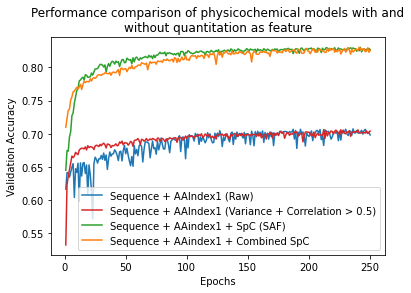

In [72]:
# plot training and validation accuracy
plt.clf()
#train_acc = history_dict['main_output_accuracy']
val_acc = df_acc['val_main_output_accuracy']

epochs = range(1, len(df_acc_aaindex1['scaled_pca']) + 1)

plt.plot(epochs, df_acc_aaindex1['raw_acc'], 'tab:blue', label='Sequence + AAIndex1 (Raw)')
plt.plot(epochs, df_acc_aaindex1['var_corr_0.5'], 'tab:red', label='Sequence + AAIndex1 (Variance + Correlation > 0.5)')
plt.plot(epochs, df_acc_saf_aaindex['val_main_output_accuracy'], 'tab:green', label='Sequence + AAindex1 + SpC (SAF)')
plt.plot(epochs, val_acc, 'tab:orange', label='Sequence + AAindex1 + Combined SpC')
# plt.plot(epochs, df_acc_aaindex1['var_corr_0.6'], 'tab:red', label='Variance + Correlation > 0.6')
# plt.plot(epochs, df_acc_aaindex1['corr_0.8'], 'tab:pink', label='Correlation > 0.8')
# plt.plot(epochs, df_acc_aaindex1['corr_0.7'], 'tab:olive', label='Correlation > 0.7')
# plt.plot(epochs, df_acc_aaindex1['corr_0.5'], 'tab:orange', label='Correlation > 0.5')
# plt.plot(epochs, df_acc_aaindex1['var_scaled'], 'tab:cyan', label='Scaled + variance threshold')

plt.title("\n".join(wrap('Performance comparison of physicochemical models with and without quantitation as feature', 60)))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
#plt.savefig('final_figures/M7_seq_combSpC_aaindex1_val_acc_comparison_134b_250ep', dpi=200)
plt.show()

## Save model

In [75]:
history.model.save("final_models/M8_seq_combSpC_aaindex1_var_corr05_REDO")

INFO:tensorflow:Assets written to: final_models/M8_seq_combSpC_aaindex1_var_corr05_REDO\assets


INFO:tensorflow:Assets written to: final_models/M8_seq_combSpC_aaindex1_var_corr05_REDO\assets


## Model evaluation

In [73]:
# train set
train_results = model.evaluate([np.asarray(X_train_peptide), np.asanyarray(X_train_quant), np.asanyarray(X_train_aaindex1_corr)], 
                               [np.asarray(y_train), np.asarray(y_train)])

print("%s: %.2f%%" % (model.metrics_names[1], train_results[1]*100))
print("%s: %.2f%%" % (model.metrics_names[3], train_results[3]*100))

1242/1242 [==============================] - ETA: 0s - loss: 0.4851 - main_output_loss: 0.3731 - aux_output_loss: 0.5600 - main_output_accuracy: 0.8327 - aux_output_accuracy: 0.703 - 3s 3ms/step - loss: 0.4846 - main_output_loss: 0.3727 - aux_output_loss: 0.5596 - main_output_accuracy: 0.8328 - aux_output_accuracy: 0.7044
main_output_loss: 37.27%
main_output_accuracy: 83.28%


In [74]:
# validation set
val_results = model.evaluate([np.asarray(X_val_peptide), np.asanyarray(X_val_quant), np.asanyarray(X_val_aaindex1_corr)], 
                             [np.asarray(y_val), np.asarray(y_val)])

print("%s: %.2f%%" % (model.metrics_names[1], val_results[1]*100))
print("%s: %.2f%%" % (model.metrics_names[3], val_results[3]*100))

414/414 [==============================] - 1s 3ms/step - loss: 0.5009 - main_output_loss: 0.3879 - aux_output_loss: 0.5653 - main_output_accuracy: 0.8257 - aux_output_accuracy: 0.6990A: 0s - loss: 0.5016 - main_output_loss: 0.3885 - aux_output_loss: 0.5655 - main_output_accuracy: 0.8259 - aux_output_accuracy: 0.698
main_output_loss: 38.79%
main_output_accuracy: 82.57%


In [76]:
# test set
test_results = model.evaluate([np.asarray(X_test_peptide), np.asanyarray(X_test_quant), np.asanyarray(X_test_aaindex1_corr)], 
                              [np.asarray(y_test), np.asarray(y_test)])

print("%s: %.2f%%" % (model.metrics_names[1], test_results[1]*100))
print("%s: %.2f%%" % (model.metrics_names[3], test_results[3]*100))

710/710 [==============================] - 2s 3ms/step - loss: 0.5040 - main_output_loss: 0.3900 - aux_output_loss: 0.5699 - main_output_accuracy: 0.8223 - aux_output_accuracy: 0.6940A: 1s - loss: 0.5078 - main_output_loss: 0.3932 - aux_output_loss: 0.5730 - main_output_accuracy: 0.8190 - aux_output_a - ETA: 0s - loss: 0.4999 - main_output_loss: 0.3860 - aux_output_loss: 0.5699 - main_output_accuracy: 0.8240 - aux_output
main_output_loss: 39.00%
main_output_accuracy: 82.23%


## Model prediction

In [77]:
df = pd.DataFrame({'Peptide': X_test['Peptide'], 'Detectability': y_test})
df.shape

(22704, 2)

In [81]:
test_predictions = model.predict([np.array([
    convertPeptide(pep, maxLength) for pep in df['Peptide']]), 
                                  np.array(X_test_quant), np.array(X_test_aaindex1_corr)], verbose=1)

710/710 [==============================] - 2s 3ms/step


In [83]:
df["Predictions"] = test_predictions[0].flatten()
df.head()

,Peptide,Detectability,Predictions
0,GYSLASLLAK,1,0.497059
1,LTSSNEINK,0,0.166428
2,ACTIAIR,0,0.195897
3,VGPVPVLVMSLLFIASVFMLHIWGK,0,0.296065
4,TLEEDVDDR,0,0.129321


In [84]:
df.to_csv('final_data/M8_PRED_seq_combSpC_aaindex1_var_corr_REDO_134b_250ep.tsv', sep='\t', index=False)

In [73]:
#df = pd.read_table('final_data/M8_PRED_seq_nsaf_aaindex1_var-corr05_134b_250ep.tsv')
df = pd.read_table('final_data/M8_PRED_seq_nsaf_aaindex1_raw_134b_250ep.tsv')

In [74]:
# visualise prediction distribution
import seaborn as sns

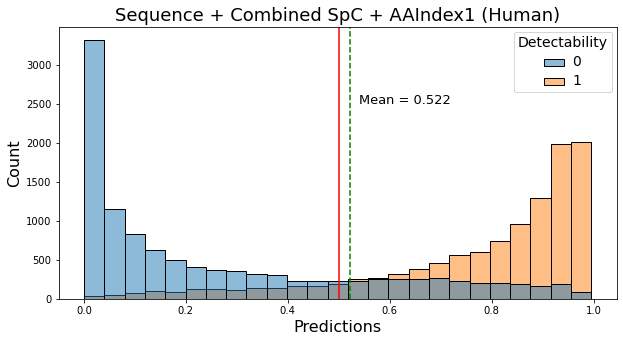

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x=df['Predictions'], hue=df['Detectability'], stat='count', bins=25)
ax.set_title('Sequence + Combined SpC + AAIndex1 (Human)', fontsize=18)

ax.set_xlabel('Predictions', fontsize=16)
ax.set_ylabel('Count', fontsize=16)

plt.axvline(x=df['Detectability'].mean(), color='r')
plt.axvline(x=df['Predictions'].mean(), color='g', ls='--')
plt.text(0.54,2500, ('Mean = {:.3f}'.format(df['Predictions'].mean())), fontsize=13)

plt.setp(ax.get_legend().get_texts(), fontsize=14)
plt.setp(ax.get_legend().get_title(), fontsize=14)

#plt.savefig('final_figures/M8_hist_seq_combSpC_aaindex1_FS.png', dpi=200)

In [89]:
# confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(df['Predictions']))
confusion_matrix

array([[8752, 2600],
       [1434, 9918]], dtype=int64)

In [90]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, np.rint(df['Predictions']))

0.822322057787174

In [91]:
# Recall
from sklearn.metrics import recall_score
recall_score(y_test, round(df['Predictions']), average='binary')

0.8736786469344608

In [92]:
# Precision
from sklearn.metrics import precision_score
precision_score(y_test, np.rint(df['Predictions']), average='binary')

0.7922990893113916

In [93]:
# F1 score
from sklearn.metrics import f1_score
f1_score(y_test, np.rint(df['Predictions']), average='binary')

0.8310012568077083

In [94]:
# MCC (Matthew's correlation coefficient)
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, np.rint(df['Predictions']))

0.6480717574951887